In [1]:
!pip install pgmpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:00


In [9]:
# General
import os
import itertools

# Data manipulation
import pandas as pd
import numpy as np

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
# Sentiment analysis
from textblob import TextBlob

# Bayesian Network modeling
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import HillClimbSearch, BicScore

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

# Google
from google.colab import drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Importing the Data

In [10]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to folder in Google Drive
folder_path = '/content/drive/MyDrive/MSc/AI/pizza_data'

# List all files in the folder
all_files = os.listdir(folder_path)
all_files


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['test.json',
 'train.json',
 'cpd_output.txt',
 'test_subset.json',
 'train_subset.json']

In [11]:
# constructing file paths
train_file_path = os.path.join(folder_path, 'train.json')
test_file_path = os.path.join(folder_path, 'test.json')


# Reading the json files
train_data = pd.read_json(train_file_path)
test_data = pd.read_json(test_file_path)

In [12]:
train_data.head()

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,...,False,[],0,1,0,1,None,nickylvst,1317852607,1317849007
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1332652424,1332648824
2,N/A,0,3,0,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,...,False,[],0,3,0,3,None,jacquibatman7,1319650094,1319646494
3,N/A,0,1,1,t3_mxvj3,4,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,...,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1322855434,1322855434
4,N/A,6,6,0,t3_1i6486,5,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,...,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1373657691,1373654091


In [13]:
X_train = train_data.drop(['requester_received_pizza'], axis=1)
y_train = train_data['requester_received_pizza']
X_test = test_data
#y_test = test_data['requester_received_pizza']

## 2. Preprocessing the data

In [14]:
# First inspecting the data to see what needs to be changed
for col in train_data.columns:
    print(col)



giver_username_if_known
number_of_downvotes_of_request_at_retrieval
number_of_upvotes_of_request_at_retrieval
post_was_edited
request_id
request_number_of_comments_at_retrieval
request_text
request_text_edit_aware
request_title
requester_account_age_in_days_at_request
requester_account_age_in_days_at_retrieval
requester_days_since_first_post_on_raop_at_request
requester_days_since_first_post_on_raop_at_retrieval
requester_number_of_comments_at_request
requester_number_of_comments_at_retrieval
requester_number_of_comments_in_raop_at_request
requester_number_of_comments_in_raop_at_retrieval
requester_number_of_posts_at_request
requester_number_of_posts_at_retrieval
requester_number_of_posts_on_raop_at_request
requester_number_of_posts_on_raop_at_retrieval
requester_number_of_subreddits_at_request
requester_received_pizza
requester_subreddits_at_request
requester_upvotes_minus_downvotes_at_request
requester_upvotes_minus_downvotes_at_retrieval
requester_upvotes_plus_downvotes_at_request
r

##2.1 Stop words, lemmatization, tokenisation

In [15]:
# Binning the columns
def bin_column(data, column_name, bins, labels):
    data[column_name] = pd.cut(data[column_name], bins=bins, labels=labels, include_lowest=True)

# Preprocessing the columns
def preprocess_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stopwords
    cleaned = [word for word in lemmatized if word.lower() not in stopwords.words('english')]
    # Joining back the words after for evaluation
    return ' '.join(cleaned)

# Reading the data
train_data = pd.read_json(train_file_path)
test_data = pd.read_json(test_file_path)

# Convert Unix timestamp to hour of the day
train_data['hour_of_request'] = pd.to_datetime(train_data['unix_timestamp_of_request_utc'], unit='s').dt.hour

train_data['request_text_length'] = train_data['request_text'].apply(len)

# Defining time bins
time_bins = [-1, 6, 12, 18, 24]  # -1 to include 0 in the first bin
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Apply binning for time
bin_column(train_data, 'hour_of_request', time_bins, time_labels)


# Define bins and labels for all other columns
age_bins = [0, 100, 200, 300, 400, 500, float('inf')]
age_labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '500+']
comments_bins = [0, 10, 20, 30, 40, 50, float('inf')]
comments_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '50+']
karma_bins = [-173, 3, 174.5, 1163.75, 155010] #using quartiles
karma_labels = ['Very Low', 'Low', 'Medium', 'High']
length_bins = [0, 125, 210, 343, 2924]
length_labels = ['Short', 'Medium', 'Long', 'Very Long']

# Apply binning for other columns
bin_column(train_data, 'requester_account_age_in_days_at_request', age_bins, age_labels)
bin_column(train_data, 'requester_number_of_comments_at_request', comments_bins, comments_labels)
bin_column(train_data, 'requester_upvotes_minus_downvotes_at_request', karma_bins, karma_labels)
bin_column(train_data, 'request_text_length', length_bins, length_labels)

# Renaming column to 'Karma' (this is used in Reddit!)
train_data.rename(columns={'requester_upvotes_minus_downvotes_at_request': 'Karma'}, inplace=True)

# Process 'request_text'
train_data['request_text'] = train_data['request_text'].apply(lambda x: preprocess_text(x))


train_data.head()


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,Karma,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,hour_of_request,request_text_length
0,N/A,0,1,0,t3_l25d7,0,Hi need food 4 child military family ha really...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0-100,...,Very Low,1,0,1,None,nickylvst,1317852607,1317849007,Evening,Long
1,N/A,2,5,0,t3_rcb83,0,spent last money gas today . Im broke next Thu...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",500+,...,Low,4258,116,11168,None,fohacidal,1332652424,1332648824,Night,Short
2,N/A,0,3,0,t3_lpu5j,0,girlfriend decided would good idea get Perth b...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0-100,...,Very Low,3,0,3,None,jacquibatman7,1319650094,1319646494,Afternoon,Long
3,N/A,0,1,1,t3_mxvj3,4,"'s cold , I'n hungry , completely honest 'm br...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",0-100,...,Low,59,76,81,None,4on_the_floor,1322855434,1322855434,Evening,Medium
4,N/A,6,6,0,t3_1i6486,5,hey guy : love sub . think 's great . ( Except...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,101-200,...,Medium,1225,1733,1887,None,Futuredogwalker,1373657691,1373654091,Afternoon,Very Long


In [16]:
karma_stats = train_data['requester_number_of_comments_at_request'].describe()
print(karma_stats)


count     4040
unique       6
top       0-10
freq      1727
Name: requester_number_of_comments_at_request, dtype: object




# 3. sentiment analysis

In [17]:
# Categorising sentiment into just positive and negative
def categorize_sentiment(text):
    analysis = TextBlob(text)

    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis
train_data['sentiment'] = train_data['request_text'].apply(categorize_sentiment)

train_data.head()


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,hour_of_request,request_text_length,sentiment
0,N/A,0,1,0,t3_l25d7,0,Hi need food 4 child military family ha really...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0-100,...,1,0,1,None,nickylvst,1317852607,1317849007,Evening,Long,Neutral
1,N/A,2,5,0,t3_rcb83,0,spent last money gas today . Im broke next Thu...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",500+,...,4258,116,11168,None,fohacidal,1332652424,1332648824,Night,Short,Negative
2,N/A,0,3,0,t3_lpu5j,0,girlfriend decided would good idea get Perth b...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0-100,...,3,0,3,None,jacquibatman7,1319650094,1319646494,Afternoon,Long,Positive
3,N/A,0,1,1,t3_mxvj3,4,"'s cold , I'n hungry , completely honest 'm br...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",0-100,...,59,76,81,None,4on_the_floor,1322855434,1322855434,Evening,Medium,Neutral
4,N/A,6,6,0,t3_1i6486,5,hey guy : love sub . think 's great . ( Except...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,101-200,...,1225,1733,1887,None,Futuredogwalker,1373657691,1373654091,Afternoon,Very Long,Positive


In [18]:
for col in train_data.columns:
    print(col)

giver_username_if_known
number_of_downvotes_of_request_at_retrieval
number_of_upvotes_of_request_at_retrieval
post_was_edited
request_id
request_number_of_comments_at_retrieval
request_text
request_text_edit_aware
request_title
requester_account_age_in_days_at_request
requester_account_age_in_days_at_retrieval
requester_days_since_first_post_on_raop_at_request
requester_days_since_first_post_on_raop_at_retrieval
requester_number_of_comments_at_request
requester_number_of_comments_at_retrieval
requester_number_of_comments_in_raop_at_request
requester_number_of_comments_in_raop_at_retrieval
requester_number_of_posts_at_request
requester_number_of_posts_at_retrieval
requester_number_of_posts_on_raop_at_request
requester_number_of_posts_on_raop_at_retrieval
requester_number_of_subreddits_at_request
requester_received_pizza
requester_subreddits_at_request
Karma
requester_upvotes_minus_downvotes_at_retrieval
requester_upvotes_plus_downvotes_at_request
requester_upvotes_plus_downvotes_at_retr

In [19]:
train_data = train_data [['request_id','requester_account_age_in_days_at_request',
                         'requester_number_of_comments_at_request', 'requester_received_pizza',
                         'Karma', 'hour_of_request','sentiment','request_text_length']]


In [20]:
train_data.head()

,request_id,requester_account_age_in_days_at_request,requester_number_of_comments_at_request,requester_received_pizza,Karma,hour_of_request,sentiment,request_text_length
0,t3_l25d7,0-100,0-10,False,Very Low,Evening,Neutral,Long
1,t3_rcb83,500+,0-10,False,Low,Night,Negative,Short
2,t3_lpu5j,0-100,0-10,False,Very Low,Afternoon,Positive,Long
3,t3_mxvj3,0-100,31-40,False,Low,Evening,Neutral,Medium
4,t3_1i6486,101-200,50+,False,Medium,Afternoon,Positive,Very Long


# 4. filling in all posibilities

In [21]:
# Ctegories for each parent node
time_categories = ['Night', 'Morning', 'Afternoon', 'Evening']
karma_categories = ['Very Low', 'Low', 'Medium', 'High']
sentiment_categories = ['Positive', 'Negative', 'Neutral']
comments_categories = ['0-10', '11-20', '21-30', '31-40', '41-50', '50+']
length_categories = ['Short', 'Medium', 'Long', 'Very Long']
age_categories = ['0-100', '101-200', '201-300', '301-400', '401-500', '500+']

# Df of all the combinations
all_combinations = pd.DataFrame(list(itertools.product(time_categories, karma_categories, sentiment_categories,
                                                       comments_categories, length_categories)),
                                columns=['hour_of_request', 'Karma', 'sentiment', 'requester_number_of_comments_at_request',
                                'request_text_length'])

# grouping the data so can evaluate how many of each
grouped = train_data.groupby(['hour_of_request', 'Karma', 'sentiment', 'requester_number_of_comments_at_request', 'request_text_length'])['requester_received_pizza'].value_counts(normalize=True).unstack(level=-1).fillna(0)

# Reset index
grouped_reset = grouped.reset_index()

# Merge with all combinations
merged = pd.merge(all_combinations, grouped_reset, how='left', on=['hour_of_request', 'Karma', 'sentiment', 'requester_number_of_comments_at_request', 'request_text_length'])

# Fill NaNs with 0 or a small probability so that if multiplied all probability dont go to zero
merged.fillna(0.0001, inplace=True)

# Convert to the shape required for CPD
values_for_cpd = merged.values[:, -2:].T



# 5. Manually Calculating Probabilities

In [22]:
# making a test CPD first
# Checking sums all equal to 1 to ensure validity of CPDS
for col_index in range(values_for_cpd.shape[1]):  # Iterate through each combination
    if np.sum(values_for_cpd[:, col_index]) != 1:  # Check if the sum is not equal to 1
        values_for_cpd[:, col_index] = [0.5, 0.5]

# Making CPD for PIZZA recieved
cpd_pizza_given_factors = TabularCPD(variable='requester_received_pizza', variable_card=2,
                                     values=values_for_cpd,
                                     evidence=['hour_of_request', 'Karma', 'sentiment',
                                               'requester_number_of_comments_at_request', 'request_text_length'],
                                     evidence_card=[4, 4, 3, 6, 4])


In [23]:
# Calculate Marginal Probabilities
def calculate_marginal_prob(data, column):
    # Count the frequency of each category normalized
    return data[column].value_counts(normalize=True)

#Function to calculate conditional probabilities
def calculate_conditional_prob(data, child, parent):
    return data.groupby(parent)[child].value_counts(normalize=True).unstack()

# Marginal Probabilities
marginal_prob_age = calculate_marginal_prob(train_data, 'requester_account_age_in_days_at_request')
marginal_prob_comments = calculate_marginal_prob(train_data, 'requester_number_of_comments_at_request')
marginal_prob_karma = calculate_marginal_prob(train_data, 'Karma')
marginal_prob_hour = calculate_marginal_prob(train_data, 'hour_of_request')
marginal_prob_sentiment = calculate_marginal_prob(train_data, 'sentiment')
marginal_prob_length = calculate_marginal_prob(train_data, 'request_text_length')

# Conditional Probabilities

# CPD - Number of Comments at Retrieval, with two parents: 'Requester Account Age' and 'Request Length'
conditional_prob_comments_given_age = train_data.groupby(['requester_account_age_in_days_at_request'])['requester_number_of_comments_at_request'].value_counts(normalize=True).unstack().fillna(0)


print("Marginal Probability - Account Age:\n", marginal_prob_age)
print("\nMarginal Probability - Number of Comments:\n", marginal_prob_comments)
print("\nMarginal Probability - Karma:\n", marginal_prob_karma)
print("\nMarginal Probability - Time of Day:\n", marginal_prob_hour)
print("\nMarginal Probability - Sentiment:\n", marginal_prob_sentiment)
print("\nMarginal Probability - Length:\n", marginal_prob_length)


#print("\nConditional Probability - Comments | Age:\n", conditional_prob_comments_given_age)
#print("\nConditional Probability - Pizza | Time, Karma, Sentiment, Length and Comments:\n", conditional_prob_pizza_given_factors)


Marginal Probability - Account Age:
 0-100      0.417079
500+       0.176238
101-200    0.140347
201-300    0.113614
301-400    0.088366
401-500    0.064356
Name: requester_account_age_in_days_at_request, dtype: float64

Marginal Probability - Number of Comments:
 0-10     0.427475
50+      0.406931
11-20    0.056931
21-30    0.044307
31-40    0.036634
41-50    0.027723
Name: requester_number_of_comments_at_request, dtype: float64

Marginal Probability - Karma:
 Very Low    0.259653
Medium      0.250000
High        0.250000
Low         0.240347
Name: Karma, dtype: float64

Marginal Probability - Time of Day:
 Evening      0.396782
Night        0.338861
Afternoon    0.219554
Morning      0.044802
Name: hour_of_request, dtype: float64

Marginal Probability - Sentiment:
 Positive    0.546287
Neutral     0.372772
Negative    0.080941
Name: sentiment, dtype: float64

Marginal Probability - Length:
 Very Long    0.445216
Long         0.244175
Medium       0.166832
Short        0.143778
Name:

# Defining the model

# 7. initializing the model for Manual Probabilities

In [24]:
model = BayesianNetwork([
    ('requester_account_age_in_days_at_request', 'requester_number_of_comments_at_request'),
    ('request_text_length', 'requester_received_pizza'),
    ('hour_of_request', 'requester_received_pizza'),
    ('Karma', 'requester_received_pizza'),
    ('sentiment', 'requester_received_pizza'),
    ('requester_number_of_comments_at_request', 'requester_received_pizza')
])


# 7.1. Visualising the model

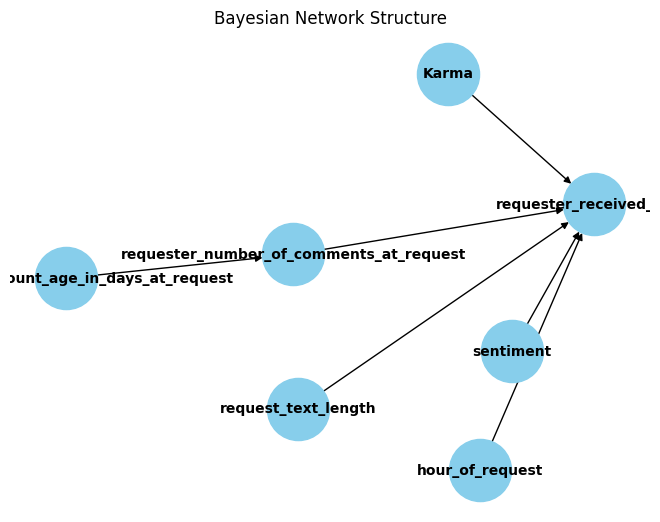

In [25]:
# Creating the graph, making sure its directed
G = nx.DiGraph()

# Adding all the nodes from the Bayesian network
G.add_edges_from([
    ('requester_account_age_in_days_at_request', 'requester_number_of_comments_at_request'),
    ('request_text_length', 'requester_received_pizza'),
    ('hour_of_request', 'requester_received_pizza'),
    ('Karma', 'requester_received_pizza'),
    ('sentiment', 'requester_received_pizza'),
    ('requester_number_of_comments_at_request', 'requester_received_pizza')
])

# Drawing out the network
nx.draw(G, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold")
plt.title("Bayesian Network Structure")
plt.show()


# 7.2 Calculating CPDs for Manual graph

In [26]:
# Adding CPDs to the model

cpd_age = TabularCPD(variable='requester_account_age_in_days_at_request', variable_card=6,
                     values=[[val] for val in marginal_prob_age.values],
                     state_names={'requester_account_age_in_days_at_request': age_categories})


cpd_length = TabularCPD(variable='request_text_length', variable_card=4,
                        values=[[val] for val in marginal_prob_length.values],
                           state_names={'request_text_length': length_categories })

cpd_hour = TabularCPD(variable='hour_of_request', variable_card=4,
                      values=[[val] for val in marginal_prob_hour.values],
                           state_names={'hour_of_request': time_categories })

cpd_karma = TabularCPD(variable='Karma', variable_card=4,
                       values=[[val] for val in marginal_prob_karma.values],
                           state_names={'Karma': karma_categories })


cpd_sentiment = TabularCPD(variable='sentiment', variable_card=3,
                           values=[[prob] for prob in marginal_prob_sentiment.values],
                           state_names={'sentiment': sentiment_categories})


# conditionals:

cpd_comments_given_age = TabularCPD(
    variable='requester_number_of_comments_at_request',
    variable_card=6,
    values=conditional_prob_comments_given_age.values.T,
    evidence=['requester_account_age_in_days_at_request'],
    evidence_card=[6],
    state_names={
        'requester_number_of_comments_at_request': comments_categories,
        'requester_account_age_in_days_at_request': age_categories
    }
)


# Conditional Probability - Pizza | Time, Karma, Sentiment, Length, and Comments

cpd_pizza_given_factors = TabularCPD(
    variable='requester_received_pizza',
    variable_card=2,  # Assuming binary outcome
    values=values_for_cpd,
    evidence=['hour_of_request', 'Karma', 'sentiment',
              'requester_number_of_comments_at_request', 'request_text_length'],
    evidence_card=[4, 4, 3, 6, 4],
    state_names={
        'hour_of_request': time_categories,
        'Karma': karma_categories,
        'sentiment': sentiment_categories,
        'requester_number_of_comments_at_request': comments_categories,
        'request_text_length': length_categories,
        'requester_received_pizza': ['False', 'True']
    }
)



In [27]:
#checking they are valid CPDS

for cpd in [cpd_age, cpd_hour, cpd_karma, cpd_sentiment, cpd_length, cpd_comments_given_age, cpd_pizza_given_factors]:
    assert cpd.is_valid_cpd(), f"Invalid CPD: {cpd.variable}"


In [28]:
# Add CPDs
model.add_cpds(cpd_age, cpd_hour, cpd_karma, cpd_sentiment, cpd_length, cpd_comments_given_age, cpd_pizza_given_factors)

# Check the model
assert model.check_model(), "Model is incorrect after adding CPDs"

print("Model is correctly set up with all CPDs.")

Model is correctly set up with all CPDs.


# 7.3. Query Manial Model

### Query 1: Probability of receiving pizza based karma and sentiment

In [29]:
# Validate the model

# Looking to answer first Q using Bayesian Network
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)

# Probability of 'requester_received_pizza' given karma and sentiment
query_result_1 = inference.query(variables=['requester_received_pizza'],
                               evidence={
                                         'Karma': 'High',
                                         'sentiment': 'Positive'})

print(query_result_1)

+---------------------------------+---------------------------------+
| requester_received_pizza        |   phi(requester_received_pizza) |
+=================================+=================================+
| requester_received_pizza(False) |                          0.7049 |
+---------------------------------+---------------------------------+
| requester_received_pizza(True)  |                          0.2951 |
+---------------------------------+---------------------------------+


## Probability of receiving pizza for a new user with low karma

In [30]:
# Query 2: Probability of receiving pizza for a new user (0-100 days old) with 'Low' karma
query_result_2 = inference.query(variables=['requester_received_pizza'],
                                 evidence={'requester_account_age_in_days_at_request': '0-100',
                                           'Karma': 'Low'})
print("Query 2 Result:\n", query_result_2)


Query 2 Result:
 +---------------------------------+---------------------------------+
| requester_received_pizza        |   phi(requester_received_pizza) |
+=================================+=================================+
| requester_received_pizza(False) |                          0.7478 |
+---------------------------------+---------------------------------+
| requester_received_pizza(True)  |                          0.2522 |
+---------------------------------+---------------------------------+


## Impact of request length and number of comments on receiving pizza

In [31]:
# Query 3: Probability of receiving pizza for a 'Medium' length request with '11-20' comments
query_result_3 = inference.query(variables=['requester_received_pizza'],
                                 evidence={'request_text_length': 'Medium',
                                           'requester_number_of_comments_at_request': '11-20'})
print("Query 3 Result:\n", query_result_3)


Query 3 Result:
 +---------------------------------+---------------------------------+
| requester_received_pizza        |   phi(requester_received_pizza) |
+=================================+=================================+
| requester_received_pizza(False) |                          0.6509 |
+---------------------------------+---------------------------------+
| requester_received_pizza(True)  |                          0.3491 |
+---------------------------------+---------------------------------+


# Query 4: For a new user (minimal account age), what combination of sentiment, time of request, and request length maximizes the probability of receiving free pizza?

In [32]:
account_age_category = '0-100'  # this is representing a new user

# Possible combinations
sentiments = ['Positive', 'Neutral', 'Negative']
times_of_day = ['Morning', 'Afternoon', 'Evening', 'Night']
request_lengths = ['Short', 'Medium', 'Long', 'Very Long']

max_probability = 0
best_scenario = None

for sentiment in sentiments:
    for time in times_of_day:
        for length in request_lengths:
            query_result = inference.query(variables=['requester_received_pizza'],
                                           evidence={'requester_account_age_in_days_at_request': account_age_category,
                                                     'sentiment': sentiment, 'hour_of_request': time,
                                                     'request_text_length': length})
            probability_of_success = query_result.values[1]  # Assuming 'True' is at index 1
            if probability_of_success > max_probability:
                max_probability = probability_of_success
                best_scenario = (sentiment, time, length)

print(f"Best scenario for a new user: {best_scenario} with a probability of {max_probability}")


Best scenario for a new user: ('Negative', 'Morning', 'Very Long') with a probability of 0.6010066251432264


# 6. Hill Climbing for Comparison

In [33]:
# Create an instance of BicScore with the training data, needed for hill climb
bic = BicScore(train_data)

# Hill Climb Search
hc = HillClimbSearch(train_data)

# Estimate the model structure
learned_model = hc.estimate(scoring_method=bic)

print("Learned Structure (Hill Climbing):", learned_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Structure (Hill Climbing): [('requester_number_of_comments_at_request', 'Karma'), ('requester_received_pizza', 'request_text_length'), ('Karma', 'requester_account_age_in_days_at_request'), ('Karma', 'requester_received_pizza'), ('request_text_length', 'sentiment')]


# 8. Visualise Learned Model

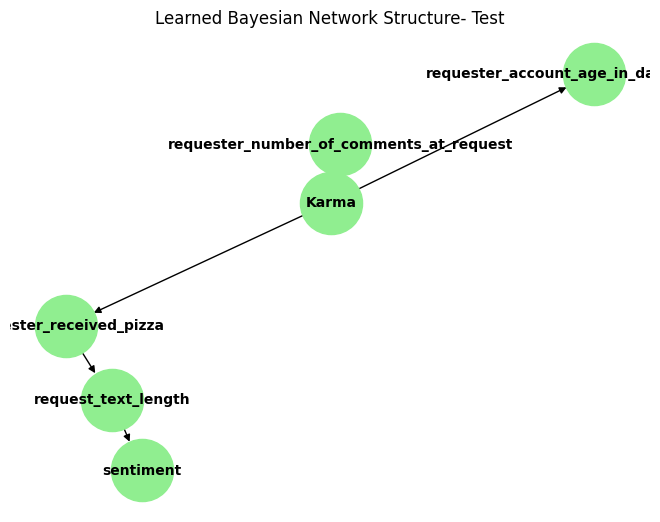

In [34]:
# Create a directed graph from the learned model
G_learned = nx.DiGraph()
G_learned.add_edges_from(learned_model.edges())

# Drawing out the network
nx.draw(G_learned, with_labels=True, node_size=2000, node_color="lightgreen", font_size=10, font_weight="bold")
plt.title("Learned Bayesian Network Structure- Test")
plt.show()


### Evaluation
We know contextually this doesnt make sense, so we cahnged around some directions and added time of day so we can compre to the other model

In [35]:
# Learned structure
learned_structure = [
    ('requester_number_of_comments_at_request', 'Karma'),
    ( 'request_text_length', 'requester_received_pizza'),
    ( 'requester_account_age_in_days_at_request','Karma'),
    ('Karma', 'requester_received_pizza'),
    ( 'sentiment','request_text_length'),
    ('hour_of_request', 'requester_received_pizza')
]

learned_model = BayesianNetwork(learned_structure)


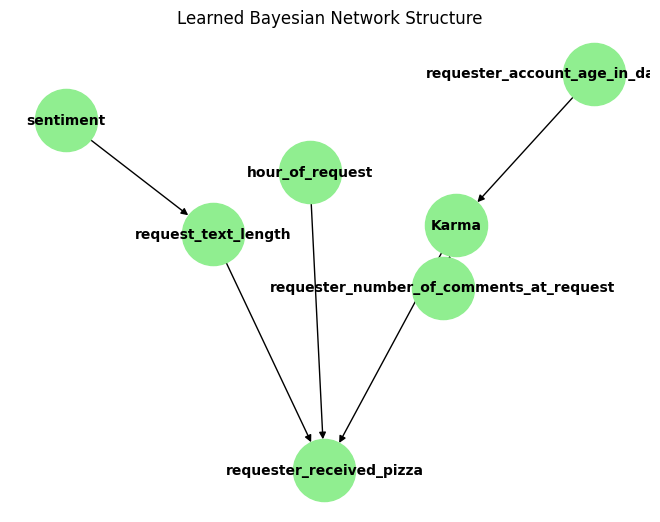

In [36]:
# Create a directed graph from the new/editrd learned model
G_learned = nx.DiGraph()
G_learned.add_edges_from(learned_model.edges())

# Drawing the network
nx.draw(G_learned, with_labels=True, node_size=2000, node_color="lightgreen", font_size=10, font_weight="bold")
plt.title("Learned Bayesian Network Structure")
plt.show()


# 8.1 Calculate CPDs for Hillclimbing method

In [37]:
# Calculating the CPDS for hill climb method
cpd_sentiment_learned = TabularCPD(variable='sentiment', variable_card=len(sentiment_categories),
                           values=[[prob] for prob in marginal_prob_sentiment.values],
                           state_names={'sentiment': sentiment_categories})

conditional_prob_karma_learned = train_data.groupby(['requester_number_of_comments_at_request', 'requester_account_age_in_days_at_request'])['Karma'].value_counts(normalize=True).unstack(fill_value=0.0001)

cpd_karma_learned = TabularCPD(
    variable='Karma',
    variable_card=len(karma_categories),
    values=conditional_prob_karma_learned.values.T,
    evidence=['requester_number_of_comments_at_request', 'requester_account_age_in_days_at_request'],
    evidence_card=[len(comments_categories), len(age_categories)],
    state_names={
        'Karma': karma_categories,
        'requester_number_of_comments_at_request': comments_categories,
        'requester_account_age_in_days_at_request': age_categories
    }
)



# Group by and calculate normalised counts
conditional_prob_pizza_learned = train_data.groupby(['Karma', 'request_text_length', 'hour_of_request'])['requester_received_pizza'].value_counts(normalize=True).unstack(fill_value=0.0001)

# Reshapeing and normalise the values
cpd_pizza_values = conditional_prob_pizza_learned.values.reshape(2, -1)
cpd_pizza_values_normalized = cpd_pizza_values / np.sum(cpd_pizza_values, axis=0)

# Conditional CPDS
cpd_pizza_learned = TabularCPD(
    variable='requester_received_pizza',
    variable_card=2,
    values=cpd_pizza_values_normalized,
    evidence=['Karma', 'request_text_length', 'hour_of_request'],
    evidence_card=[len(karma_categories), len(length_categories), len(time_categories)],
    state_names={
        'requester_received_pizza': ['False', 'True'],
        'Karma': karma_categories,
        'request_text_length': length_categories,
        'hour_of_request': time_categories
    }
)



conditional_prob_length_learned = train_data.groupby('sentiment')['request_text_length'].value_counts(normalize=True).unstack(fill_value=0.0001)
cpd_length_learned = TabularCPD(
    variable='request_text_length',
    variable_card=len(length_categories),
    values=conditional_prob_length_learned.values.T,
    evidence=['sentiment'],
    evidence_card=[len(sentiment_categories)],
    state_names={
        'request_text_length': length_categories,
        'sentiment': sentiment_categories
    }
)



cpd_age_learned = TabularCPD(variable='requester_account_age_in_days_at_request', variable_card=6,
                     values=[[val] for val in marginal_prob_age.values],
                     state_names={'requester_account_age_in_days_at_request': age_categories}
)

cpd_hour_learned = TabularCPD(variable='hour_of_request', variable_card=4,
                      values=[[val] for val in marginal_prob_hour.values],
                           state_names={'hour_of_request': time_categories })

cpd_comments_learned = TabularCPD(
    variable='requester_number_of_comments_at_request',
    variable_card=len(comments_categories),
    values=[[val] for val in marginal_prob_comments.values],
    state_names={'requester_number_of_comments_at_request': comments_categories}

)




In [38]:
# List to store all CPDs and their names
cpds = [
    (cpd_sentiment_learned, 'sentiment'),
    (cpd_karma_learned, 'Karma'),
    (cpd_pizza_learned, 'requester_received_pizza'),
    (cpd_length_learned, 'request_text_length'),
    (cpd_age_learned, 'requester_account_age_in_days_at_request'),
    (cpd_comments_learned, 'requester_number_of_comments_at_request'),
    (cpd_hour_learned, 'hour_of_request')
]

# Loop through each CPD and print its state names
for cpd, name in cpds:
    print(f"State names for {name}: {cpd.state_names}")
    print()  # Just for better readability


State names for sentiment: {'sentiment': ['Positive', 'Negative', 'Neutral']}

State names for Karma: {'Karma': ['Very Low', 'Low', 'Medium', 'High'], 'requester_number_of_comments_at_request': ['0-10', '11-20', '21-30', '31-40', '41-50', '50+'], 'requester_account_age_in_days_at_request': ['0-100', '101-200', '201-300', '301-400', '401-500', '500+']}

State names for requester_received_pizza: {'requester_received_pizza': ['False', 'True'], 'Karma': ['Very Low', 'Low', 'Medium', 'High'], 'request_text_length': ['Short', 'Medium', 'Long', 'Very Long'], 'hour_of_request': ['Night', 'Morning', 'Afternoon', 'Evening']}

State names for request_text_length: {'request_text_length': ['Short', 'Medium', 'Long', 'Very Long'], 'sentiment': ['Positive', 'Negative', 'Neutral']}

State names for requester_account_age_in_days_at_request: {'requester_account_age_in_days_at_request': ['0-100', '101-200', '201-300', '301-400', '401-500', '500+']}

State names for requester_number_of_comments_at_request

In [39]:
# Add all CPDs to the learned model
learned_model.add_cpds(cpd_karma_learned, cpd_pizza_learned, cpd_length_learned, cpd_age_learned,cpd_comments_learned, cpd_sentiment_learned, cpd_hour_learned)


In [40]:
# Check if the model is correctly specified
is_correct = learned_model.check_model()

# If the model is incorrect, identify the problematic CPDs
if not is_correct:
    for cpd in learned_model.get_cpds():
        if not cpd.is_valid_cpd():
            print(f"Invalid CPD: {cpd.variable}")
else:
    print("The model is correctly specified.")

is_correct

The model is correctly specified.


True

# Query Hill Climbing Model

In [41]:
# Initialising the inference object
inference_learned = VariableElimination(learned_model)


## Probability of 'requester_received_pizza' given a positive sentiment and high karma

In [42]:
query_result_1_learned = inference_learned.query(
    variables=['requester_received_pizza'],
    evidence={ 'Karma': 'High', 'sentiment': 'Positive'}
)
print("Query 1 Result:\n", query_result_1_learned)


Query 1 Result:
 +---------------------------------+---------------------------------+
| requester_received_pizza        |   phi(requester_received_pizza) |
+=================================+=================================+
| requester_received_pizza(False) |                          0.4983 |
+---------------------------------+---------------------------------+
| requester_received_pizza(True)  |                          0.5017 |
+---------------------------------+---------------------------------+


## Probability of receiving pizza for a new user with low karma

In [43]:
query_result_2_learned = inference_learned.query(
    variables=['requester_received_pizza'],
    evidence={'requester_account_age_in_days_at_request': '0-100', 'Karma': 'Low'}
)
print("Query 2 Result:\n", query_result_2_learned)

Query 2 Result:
 +---------------------------------+---------------------------------+
| requester_received_pizza        |   phi(requester_received_pizza) |
+=================================+=================================+
| requester_received_pizza(False) |                          0.4793 |
+---------------------------------+---------------------------------+
| requester_received_pizza(True)  |                          0.5207 |
+---------------------------------+---------------------------------+


## Impact of request length and number of comments on receiving pizza

In [44]:
query_result_3_learned = inference_learned.query(
    variables=['requester_received_pizza'],
    evidence={'request_text_length': 'Medium', 'requester_number_of_comments_at_request': '11-20'}
)
print("Query 3 Result:\n", query_result_3_learned)

Query 3 Result:
 +---------------------------------+---------------------------------+
| requester_received_pizza        |   phi(requester_received_pizza) |
+=================================+=================================+
| requester_received_pizza(False) |                          0.4727 |
+---------------------------------+---------------------------------+
| requester_received_pizza(True)  |                          0.5273 |
+---------------------------------+---------------------------------+


# Query 4: Best options for New Users

In [45]:

max_probability_learned = 0
best_scenario_learned = None

for sentiment in sentiments:
    for time in times_of_day:
        for length in request_lengths:
            query_result_learned = inference_learned.query(variables=['requester_received_pizza'],
                                                evidence={'requester_account_age_in_days_at_request': account_age_category,
                                                          'sentiment': sentiment, 'hour_of_request': time,
                                                          'request_text_length': length})
            probability_of_success_learned = query_result_learned.values[1]  # as true =1
            if probability_of_success_learned > max_probability_learned:
                max_probability_learned = probability_of_success_learned
                best_scenario_learned = (sentiment, time, length)

print(f"Best scenario for a new user (Hill Climb Model): {best_scenario_learned} with a probability of {max_probability_learned}")


Best scenario for a new user (Hill Climb Model): ('Positive', 'Morning', 'Long') with a probability of 0.6920718572884124


# comparing Results Q 1-3

In [46]:
def compare_query_results(query_result_manual, query_result_learned, query_number):
    print(f"Comparison of Query {query_number} Results:")

    # Extracting probabilities from the manual model
    prob_manual_false = query_result_manual.values[0]
    prob_manual_true = query_result_manual.values[1]

    # Extracting probabilities from the learned model
    prob_learned_false = query_result_learned.values[0]
    prob_learned_true = query_result_learned.values[1]

    # Printing comparison
    print(f"Manual Model: False = {prob_manual_false}, True = {prob_manual_true}")
    print(f"Learned Model: False = {prob_learned_false}, True = {prob_learned_true}")
    print()



# Compare the results for each query
compare_query_results(query_result_1, query_result_1_learned, 1)
compare_query_results(query_result_2, query_result_2_learned, 2)
compare_query_results(query_result_3, query_result_3_learned, 3)


Comparison of Query 1 Results:
Manual Model: False = 0.7049197261306304, True = 0.29508027386936964
Learned Model: False = 0.49825352928153677, True = 0.5017464707184632

Comparison of Query 2 Results:
Manual Model: False = 0.7477786551618488, True = 0.2522213448381513
Learned Model: False = 0.4793253332568484, True = 0.5206746667431517

Comparison of Query 3 Results:
Manual Model: False = 0.6509084041284243, True = 0.34909159587157573
Learned Model: False = 0.4726578862860561, True = 0.527342113713944



In [50]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook (.ipynb file)
notebook_path = "/content/drive/MyDrive/MSc/AI/AI_CW1.ipynb"
with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
    notebook_content = nbformat.read(notebook_file, as_version=4)

# Convert to HTML
html_exporter = HTMLExporter()
(html_output, resources) = html_exporter.from_notebook_node(notebook_content)

# Save the HTML output to a file
output_path = "/content/drive/MyDrive/MSc/AI/AI_CW1_Final_1.html"
with open(output_path, 'w', encoding='utf-8') as output_file:
    output_file.write(html_output)
